In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

# import nctpy functions
sys.path.extend(['/Users/lindenmp/Google-Drive-Personal/work/research_projects/nctpy/src'])
from nctpy.energies import integrate_u, get_control_inputs
from nctpy.pipelines import ComputeControlEnergy, ComputeOptimizedControlEnergy
from nctpy.metrics import ave_control
from nctpy.utils import (
    matrix_normalization,
    convert_states_str2int,
    normalize_state,
    normalize_weights,
    get_null_p,
    get_fdr_p,
)
from nctpy.plotting import roi_to_vtx, null_plot, surface_plot, add_module_lines, set_plotting_params
from null_models.geomsurr import geomsurr
set_plotting_params()

# Protocol Pathway A: Control Energy

### Load adjacency

In [2]:
# directory where data is stored
datadir = "/Users/lindenmp/Google-Drive-Personal/work/research_projects/nctpy/data"
resultsdir = "/Users/lindenmp/Google-Drive-Personal/work/research_projects/nctpy/results"
adjacency_file = "normalized_connection_strength_ipsi.csv"
# adjacency_file = 'connection_strength_ipsi.csv'

In [3]:
# load adjacency matrix
adjacency = np.loadtxt(os.path.join(datadir, adjacency_file), dtype=float, delimiter=",", encoding="utf-8-sig")
adjacency = adjacency.T  # set rows=tagets and columns=sources. That is, Aij = edge from node j to node i

# load region class
region_class = pd.read_csv(os.path.join(datadir, "region_class.csv"))

# retain isocortex
idx = region_class["Isocortex"] == 1
# subset adjacency
adjacency = adjacency[region_class[idx].index, :][:, region_class[idx].index]
n_nodes = adjacency.shape[0]
print(adjacency.shape)

# get density including self connections
density = np.count_nonzero(adjacency) / adjacency.shape[0] ** 2
print(density)

# subset region_class
region_class = region_class[idx]

# sort on Isocortex_modules
region_class.reset_index(inplace=True, drop=True)
region_class["sort_idx"] = region_class.index
region_class.sort_values("Isocortex_modules", inplace=True)
region_class.reset_index(inplace=True, drop=True)
# sort adjacency to match
adjacency = adjacency[region_class.sort_idx, :][:, region_class.sort_idx]

print(region_class)

(43, 43)
1.0
     Region  Class  Isocortex Isocortex_modules  sort_idx
0      AUDv      0          1          Auditory        16
1     AUDpo      0          1          Auditory        15
2      AUDp      0          1          Auditory        14
3      AUDd      0          1          Auditory        13
4       ECT     12          1           Lateral        42
5      PERI     12          1           Lateral        41
6        GU     12          1           Lateral        11
7       AId      0          1           Lateral        32
8      VISC     12          1           Lateral        12
9       AIv      0          1           Lateral        34
10      TEa     12          1           Lateral        40
11      AIp      0          1           Lateral        33
12   RSPagl      0          1            Medial        35
13     RSPd      0          1            Medial        36
14     RSPv      0          1            Medial        37
15     VISa      0          1            Medial        38
1

### Plot adjacency

['Auditory' 'Lateral' 'Medial' 'PFC' 'Somatomotor' 'Visual']


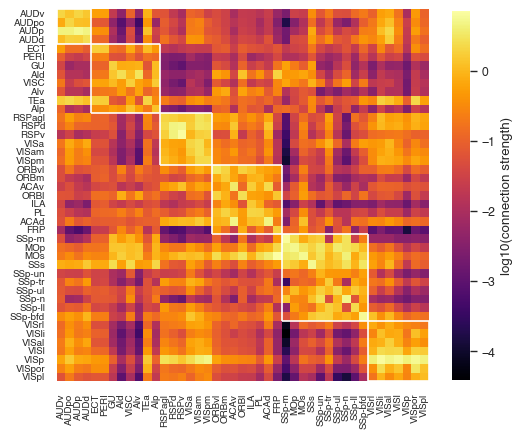

In [4]:
# plot adjacency matrix
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    np.log10(adjacency),
    ax=ax,
    square=True,
    cmap="inferno",
    xticklabels=region_class.Region,
    yticklabels=region_class.Region,
    cbar_kws={"label": "log10(connection strength)", "shrink": 0.8},
)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=7)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=7)
add_module_lines(region_class["Isocortex_modules"], ax)
f.savefig(
    os.path.join(resultsdir, "mouse_connectome.png"),
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()

### Assign isocortex to DMN based on Whitesell 2021 Neuron

In [5]:
# Whitesell DMN regions
dmn_regions = [
    "ACAd",
    "ACAv",
    "PL",
    "ILA",
    "ORBl",
    "ORBm",
    "ORBvl",
    "VISa",
    "VISam",
    "RSPagl",
    "RSPd",
    "RSPv",
    "SSp-tr",
    "SSp-ll",
    "MOs",
]

region_class.set_index("Region", inplace=True)
region_class["DMN"] = np.zeros(n_nodes).astype(bool)
for idx in dmn_regions:
    region_class.loc[idx, "DMN"] = True
region_class.reset_index(inplace=True, drop=False)

# create new system labels column that uses DMN to overwrite existing modules
region_class["system_labels"] = region_class["Isocortex_modules"]
region_class.loc[region_class["DMN"], "system_labels"] = "DMN"

print(region_class)

     Region  Class  Isocortex Isocortex_modules  sort_idx    DMN system_labels
0      AUDv      0          1          Auditory        16  False      Auditory
1     AUDpo      0          1          Auditory        15  False      Auditory
2      AUDp      0          1          Auditory        14  False      Auditory
3      AUDd      0          1          Auditory        13  False      Auditory
4       ECT     12          1           Lateral        42  False       Lateral
5      PERI     12          1           Lateral        41  False       Lateral
6        GU     12          1           Lateral        11  False       Lateral
7       AId      0          1           Lateral        32  False       Lateral
8      VISC     12          1           Lateral        12  False       Lateral
9       AIv      0          1           Lateral        34  False       Lateral
10      TEa     12          1           Lateral        40  False       Lateral
11      AIp      0          1           Lateral     

### Get states

In [6]:
# get system labels
system_labels = list(region_class["system_labels"])

In [7]:
print(len(system_labels))
print(system_labels[:20])

43
['Auditory', 'Auditory', 'Auditory', 'Auditory', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'DMN', 'DMN', 'DMN', 'DMN', 'DMN', 'Medial', 'DMN', 'DMN']


In [8]:
# use list of system names to create states
states, state_labels = convert_states_str2int(system_labels)

### Setup control tasks

In [9]:
# initialize list of control tasks
control_tasks = []

# define control nodes using a uniform full control set
# note, here we use the same control nodes for all control tasks
control_set = np.eye(n_nodes)

# define state trajectory constraint nodes.
# note, here we constrain the full state trajectory equally for all control tasks
trajectory_constraints = np.eye(n_nodes)

# define mixing parameter
rho = 1

initial_state = states == state_labels.index("DMN")
initial_state = normalize_state(initial_state)  # normalize state magnitude

# assemble control tasks
for i in ["Lateral", "Visual", "Auditory"]:
    target_state = states == state_labels.index(i)
    target_state = normalize_state(target_state)  # normalize state magnitude

    # i to j
    control_task = dict()  # initialize dict
    control_task["x0"] = initial_state  # store initial state
    control_task["xf"] = target_state  # store target state
    control_task["B"] = control_set  # store control nodes
    control_task["S"] = trajectory_constraints  # store state trajectory constraints
    control_task["rho"] = rho  # store rho
    control_tasks.append(control_task)

    # j back to i
    control_task = dict()  # initialize dict
    control_task["x0"] = target_state  # store initial state
    control_task["xf"] = initial_state  # store target state
    control_task["B"] = control_set  # store control nodes
    control_task["S"] = trajectory_constraints  # store state trajectory constraints
    control_task["rho"] = rho  # store rho
    control_tasks.append(control_task)

### Run ComputeControlEnergy

In [10]:
# compute control energy across all control tasks
compute_control_energy = ComputeControlEnergy(
    A=adjacency, control_tasks=control_tasks, system="continuous", c=1, T=1
)
compute_control_energy.run()

# reshape to set DMN-to-X on first column and X-to-DMN on second column
energy = np.reshape(compute_control_energy.E, (3, 2))  # reshape energy
energy_delta = energy[:, 1] - energy[:, 0]  # get energy asymmetries
print(energy)
print(energy_delta)

100%|██████████| 6/6 [00:04<00:00,  1.21it/s]

[[2724.37609829 1944.85054695]
 [2406.76108952 2211.65778753]
 [2437.44752492 2081.29461031]]
[-779.52555135 -195.10330199 -356.15291461]


### Re-run ComputeControlEnergy using symmetric mouse connectome

In [11]:
adjacency_symmetric = (adjacency + adjacency.T) / 2  # symmetrize mouse connectome

# compute control energy across all control tasks
compute_control_energy = ComputeControlEnergy(
    A=adjacency_symmetric, control_tasks=control_tasks, system="continuous", c=1, T=1
)
compute_control_energy.run()

# reshape to set DMN-to-X on first column and X-to-DMN on second column
energy_symmetric = np.reshape(compute_control_energy.E, (3, 2))  # reshape energy
energy_symmetric_delta = energy_symmetric[:, 1] - energy_symmetric[:, 0]  # get energy asymmetries
print(energy_symmetric)
print(energy_symmetric_delta)

100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

[[2629.9971009  1981.65371474]
 [2313.32338045 2134.434777  ]
 [2372.15441145 2107.89956547]]
[-648.34338616 -178.88860345 -264.25484598]


In [12]:
# get differences in energy asymmetries between directed and undirected connectome
asym_dif = np.abs(energy_delta) - np.abs(energy_symmetric_delta)
print(asym_dif)


# get percent change in energy asymmetries
def perc_change(x, y):
    return np.round((y - x) / np.abs(x) * 100)


asym_dif_perc = []
for i in np.arange(len(asym_dif)):
    asym_dif_perc.append(perc_change(np.abs(energy_symmetric_delta[i]), np.abs(energy_delta[i])))
print(asym_dif_perc)

[131.18216519  16.21469854  91.89806863]
[20.0, 9.0, 35.0]


## Plot results

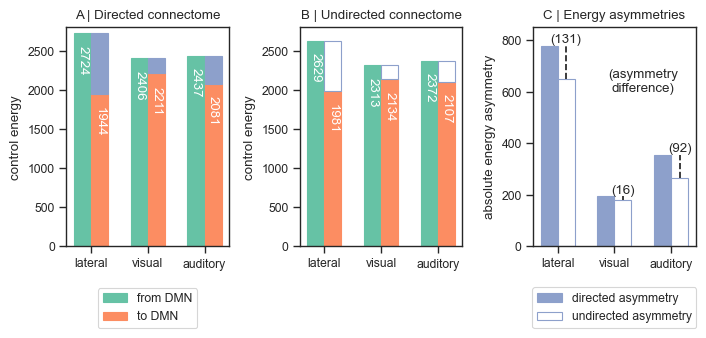

In [13]:
cmap = sns.color_palette("Set2")
sns.set_style(style='ticks')

labels = ["lateral", "visual", "auditory"]
x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

f, ax = plt.subplots(1, 3, figsize=(7.15, 3.75))

# directed adjacency matrix
rects1 = ax[0].bar(
    x - width / 2,
    energy[:, 0],
    color=cmap[0],
    edgecolor=cmap[0],
    width=width,
    label="from DMN",
)
rects2 = ax[0].bar(
    x + width / 2,
    energy[:, 1],
    color=cmap[1],
    edgecolor=cmap[1],
    width=width,
    label="to DMN",
)
rects3 = ax[0].bar(
    x + width / 2,
    np.abs(energy_delta),
    bottom=energy[:, 1],
    # color="w",
    color=cmap[2],
    edgecolor=cmap[2],
    # hatch="///",
    width=width,
)

ax[0].set_title("A | Directed connectome")
ax[0].set_ylabel("control energy")
ax[0].set_xticks(x, labels)
ax[0].legend(bbox_to_anchor=(0.5, -0.4), loc="lower center")
ax[0].set_ylim([0, 2800])

ax[0].bar_label(rects1, padding=-30, fmt="%i", rotation=270, color="w")
ax[0].bar_label(rects2, padding=-30, fmt="%i", rotation=270, color="w")

# undirected adjacency matrix
rects1 = ax[1].bar(
    x - width / 2,
    energy_symmetric[:, 0],
    color=cmap[0],
    edgecolor=cmap[0],
    width=width,
    label="from DMN",
)
rects2 = ax[1].bar(
    x + width / 2,
    energy_symmetric[:, 1],
    color=cmap[1],
    edgecolor=cmap[1],
    width=width,
    label="to DMN",
)
rects3 = ax[1].bar(
    x + width / 2,
    np.abs(energy_symmetric_delta),
    bottom=energy_symmetric[:, 1],
    color="w",
    edgecolor=cmap[2],
    width=width,
    label="Asymmetry (abs.)",
)

ax[1].set_title("B | Undirected connectome")
ax[1].set_ylabel("control energy")
ax[1].set_xticks(x, labels)
ax[1].set_ylim([0, 2800])

ax[1].bar_label(rects1, padding=-30, fmt="%i", rotation=270, color="w")
ax[1].bar_label(rects2, padding=-30, fmt="%i", rotation=270, color="w")

# asymmetries
rects1 = ax[2].bar(
    x - width / 2,
    np.abs(energy_delta),
    # color="w",
    color=cmap[2],
    edgecolor=cmap[2],
    # hatch="///",
    width=width,
    label="directed asymmetry",
)
rects2 = ax[2].bar(
    x + width / 2,
    np.abs(energy_symmetric_delta),
    color="w",
    edgecolor=cmap[2],
    width=width,
    label="undirected asymmetry",
)

ax[2].set_title("C | Energy asymmetries")
ax[2].set_ylabel("absolute energy asymmetry")
ax[2].set_xticks(x, labels)
ax[2].set_ylim([0, 850])

for i, p in enumerate(rects2):
    height = p.get_height()
    ax[2].text(
        x=p.get_x() + p.get_width() / 2,
        y=height + asym_dif[i] + 10,
        s="({:.0f})".format(asym_dif[i]),
        ha="center",
    )
    ax[2].axvline(
        x=p.get_x() + p.get_width() / 2,
        ymin=height / 850,
        ymax=(height + asym_dif[i]) / 850,
        color="k",
        linestyle="--",
    )
ax[2].text(x=1.5, y=600, s="(asymmetry\ndifference)", ha="center")
ax[2].legend(bbox_to_anchor=(0.5, -0.4), loc="lower center")

f.tight_layout()
f.savefig(
    os.path.join(resultsdir, "mouse_energy.png"),
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()